In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
%pylab inline
plt.rcParams["figure.figsize"] = (6,6)

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


2D Ising Gauge Hamiltonian:
$
H = \sum_p \Pi_{i\in p} \sigma^z_i
$

In [8]:
def plot_configuration(spins, dual=False):
    '''
    
    this is just a helper function to plot the configuration of spins  given by 'spins'
    note that (i,j) denotes a vertex coordinate, such that the location of the plaquette
    center is at (i+0.5, j+0.5) and thus, the x spin is at (i+1, j+0.5) etc.
    
    Parameters
    ----------
    spins  :  int
        spin configuration, dimension is NxNx2
    dual   :  bool
        Plot the configuration in dual space or not. Default is False.
    '''
    N = np.shape(spins)[1]
    fig, ax = plt.subplots()
    fig.add_axes()
    ax = fig.axes[0]
    for i in range(N+1):
        ax.plot([i, i], [0,N], 'k')
        ax.plot([0,N], [i,i], 'k')
    
    if not dual:
        colors = ['b', 'gold'] # note: blue is down, red is up!
        for i in range(N):
            fig.gca().add_patch(plt.Circle((0,i+0.5), radius=0.2, fc=colors[int((spins[-1,i,0]+1)/2.)]))
            fig.gca().add_patch(plt.Circle((i+0.5,0), radius=0.2, fc=colors[int((spins[i,-1,1]+1)/2.)]))
            for j in range(N):
                fig.gca().add_patch(plt.Circle((i+1,j+0.5), radius=0.2, fc=colors[int((spins[i,j,0]+1)/2.)]))
                fig.gca().add_patch(plt.Circle((i+0.5,j+1), radius=0.2, fc=colors[int((spins[i,j,1]+1)/2.)]))
    
    if dual:
        excitation = []
        for i in range(N):
            if spins[-1, i,0]==1: ax.plot([-0.5, 0.5], [i+0.5, i+0.5], 'b', lw=3)
            if spins[i, -1,1]==1: ax.plot([i+0.5, i+0.5], [-0.5, 0.5], 'b', lw=3)
            for j in range(N):
                j_up = (N+j-1)%N
                i_left = (i+N-1)%N
                if spins[i,j,0]==1: ax.plot([i+0.5, i+1.5], [j+0.5, j+0.5], 'b', lw=3)
                if spins[i,j,1]==1: ax.plot([i+0.5, i+0.5], [j+0.5, j+1.5], 'b', lw=3)
                if spins[i,j, 0]*spins[i_left, j, 0]*spins[i,j,1]*spins[i,j_up, 1]==-1: excitation.append([i+0.5,j+0.5])
        if len(excitation)>0: plt.scatter(np.array(excitation)[:,0], np.array(excitation)[:,1], color='red', s=350, marker=(5,1))
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('off')
    fig.show()

In [27]:
configs = np.loadtxt("configs.txt")
labels = np.loadtxt("labels.txt")
N = int(np.sqrt(np.shape(configs[0])[0]/2))
print("loaded %i configurations of size %ix%i for training"%(len(configs), N,N))

loaded 2000 configurations of size 16x16 for training


In [26]:
test_config = np.loadtxt("test_configs.txt")
test_labels = np.loadtxt("test_labels.txt")
N = int(np.sqrt(np.shape(configs[0])[0]/2))
print("loaded %i test configurations of size %ix%i for training"%(len(configs), N,N))

loaded 2000 test configurations of size 16x16 for training


In [6]:
# prepare data for training
x = configs
y = [(i%2,(i+1)%2) for i in labels]

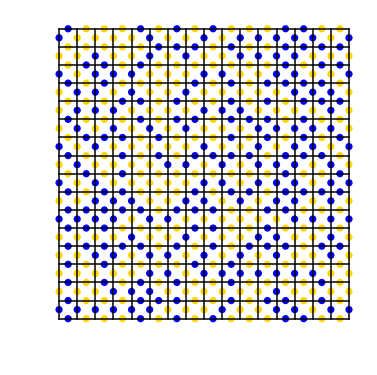

In [9]:
plot_configuration(np.reshape(configs[0], (N,N,2)))

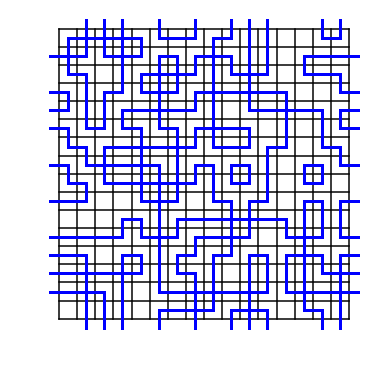

In [10]:
plot_configuration(np.reshape(configs[0], (N,N,2)), dual=True)

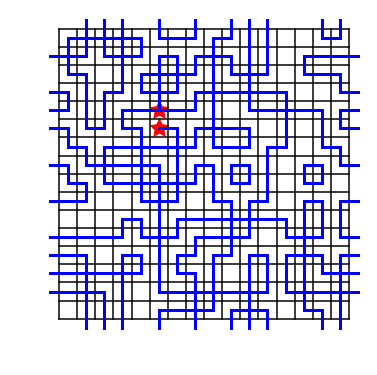

In [29]:
# just to show how excitations / defects are shown in 'dual' mode
single_excitation = copy(configs[0])
i = 11
j = 5
single_excitation[i*N+j]*=-1
plot_configuration(np.reshape(single_excitation, (N,N,2)), dual=True)

## Dense model to check

In [13]:
# create a simple dense model model
model = Sequential()
model.add(Dense(100, input_dim=2*N**2, kernel_initializer='random_normal', activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, kernel_initializer='random_normal', activation='softmax', kernel_regularizer=regularizers.l2(0.0)))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.fit(x, y, epochs=50, batch_size=32,  verbose=0)

In [16]:
test_y = [(i%2,(i+1)%2) for i in test_labels]

In [17]:
print("evaluate the model on the test set and print out %s and %s" %(model.metrics_names[0], model.metrics_names[1]))
model.evaluate(test_config, test_y)

evaluate the model on the test set and print out loss and acc
2000/2000 [==============================] - 0s 55us/step1568/2000 [======================>.......] - ETA: 0s


[0.82491593170166011, 0.50549999999999995]

## deeper dense network

just for the fun of it

In [18]:
# create model
model2 = Sequential()
model2.add(Dense(100, input_dim=2*N**2, kernel_initializer='random_normal', activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(50, kernel_initializer='random_normal', activation='sigmoid', kernel_regularizer=regularizers.l2(0.0)))
model2.add(Dense(2, kernel_initializer='random_normal', activation='softmax', kernel_regularizer=regularizers.l2(0.0)))

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model2.fit(x, y, epochs=50, batch_size=32,  verbose=0) # use verbose=1 or =2 to see more progress information.

In [20]:
print("evaluate the deeper dense model on the test set and print out %s and %s" %(model.metrics_names[0], model.metrics_names[1]))
model.evaluate(test_config, test_y)

evaluate the deeper dense model on the test set and print out loss and acc
2000/2000 [==============================] - 0s 41us/step1120/2000 [===============>..............] - ETA: 0s


[0.82491593170166011, 0.50549999999999995]

## convolution NN

In [21]:
# just this once, for demonstartion purposes, we shall import stuff not on the top ;)
from keras.layers import Conv2D, Dropout, Flatten

In [22]:
# Note that here now, the input shape actually matters!
x = np.array([np.reshape(config, (N,N,2)) for config in configs])

In [23]:
def create_periodic_padding(configs, kernel_size):
    N = np.shape(configs)[1]
    padding = kernel_size-1
    x = []
    for config in configs:
        padded = np.zeros((N+2*padding, N+2*padding, 2))
        # lower left corner
        padded[:padding,:padding, :] = config[N-padding:,N-padding:,:]
        # lower middle
        padded[padding:N+padding, :padding, :] = config[:,N-padding:,:]
        # lower right corner
        padded[N+padding:, :padding, :] = config[:padding, N-padding:, :]
        # left side
        padded[:padding, padding:N+padding, :] = config[N-padding:, :, :]
        # center
        padded[padding:N+padding, padding:N+padding, :] = config[:,:,:]
        # right side
        padded[N+padding:, padding:N+padding, :] = config[:padding, :, :]
        # top left corner
        padded[:padding, N+padding:,:] = config[N-padding:, :padding, :]
        # top middle
        padded[padding:N+padding, N+padding:, :] = config[:, :padding, :]
        # top right corner
        padded[N+padding:, N+padding:, :] = config[:padding, :padding, :]
        x.append(padded)
    return np.array(x)

In [55]:
# we want to be able to use different kernel sizes and compare
def convolutional_model(kernel_size):
    input_size = 16+2*(kernel_size-1)
    model = Sequential()
    model.add(Conv2D(64, (kernel_size, kernel_size), strides=1, input_shape=(input_size,input_size,2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [56]:
test_x = np.array([np.reshape(config, (N,N,2)) for config in test_config])

In [57]:
# Warning: this will take a while...
kernel_sizes=[2,3,4,5,6,7,8]
accuracy = []
runs = 20
for kernel_size in kernel_sizes:
    print("Kernel size is %ix%i"%(kernel_size,kernel_size))
    x_n = create_periodic_padding(x,kernel_size)
    test_x_n = create_periodic_padding(test_x, kernel_size)
    for i in range(runs):
        print("run %i of %i"%(i+1, runs))
        model = convolutional_model(kernel_size)
        model.fit(x_n,y,epochs=50, batch_size=32, verbose=0)
        scores = model.evaluate(test_x_n, test_y, verbose=0)
        acc = scores[1]*100
        print("accuracy is {0}%".format(acc))
        accuracy.append(acc)

Kernel size is 2x2
run 1 of 20
accuracy is 100.0%
run 2 of 20
accuracy is 100.0%
run 3 of 20
accuracy is 100.0%
run 4 of 20
accuracy is 100.0%
run 5 of 20
accuracy is 100.0%
run 6 of 20
accuracy is 100.0%
run 7 of 20
accuracy is 100.0%
run 8 of 20
accuracy is 100.0%
run 9 of 20
accuracy is 100.0%
run 10 of 20
accuracy is 100.0%
run 11 of 20
accuracy is 100.0%
run 12 of 20
accuracy is 100.0%
run 13 of 20
accuracy is 100.0%
run 14 of 20
accuracy is 100.0%
run 15 of 20
accuracy is 100.0%
run 16 of 20
accuracy is 100.0%
run 17 of 20
accuracy is 100.0%
run 18 of 20
accuracy is 100.0%
run 19 of 20
accuracy is 100.0%
run 20 of 20
accuracy is 100.0%
Kernel size is 3x3
run 1 of 20
accuracy is 99.875%
run 2 of 20
accuracy is 100.0%
run 3 of 20
accuracy is 100.0%
run 4 of 20
accuracy is 100.0%
run 5 of 20
accuracy is 100.0%
run 6 of 20
accuracy is 100.0%
run 7 of 20
accuracy is 100.0%
run 8 of 20
accuracy is 100.0%
run 9 of 20
accuracy is 100.0%
run 10 of 20
accuracy is 100.0%
run 11 of 20
accura

In [58]:
# this is only needed to fool around with the simulation results and plot.
from pandas import DataFrame

In [60]:
acc = np.reshape(np.array(accuracy), (7, 20))

In [61]:
accur = {}
accur['2']=acc[0]
accur['3']=acc[1]
accur['4']=acc[2]
accur['5']=acc[3]
accur['6']=acc[4]
accur['7']=acc[5]
accur['8']=acc[6]

In [62]:
results = DataFrame(accur)
print(results.describe())

           2          3           4          5          6          7  \
count   20.0   20.00000   20.000000   20.00000  20.000000  20.000000   
mean   100.0   99.99000   95.033750   69.54625  50.483750  50.661250   
std      0.0    0.03183   15.206217   23.84929   0.664726   0.669027   
min    100.0   99.87500   49.950000   49.62500  49.150000  49.475000   
25%    100.0  100.00000   99.993750   50.59375  50.050000  50.143750   
50%    100.0  100.00000  100.000000   51.23750  50.450000  50.662500   
75%    100.0  100.00000  100.000000   98.71875  50.931250  51.093750   
max    100.0  100.00000  100.000000  100.00000  51.925000  52.075000   

               8  
count  20.000000  
mean   50.598750  
std     0.789215  
min    49.575000  
25%    50.000000  
50%    50.387500  
75%    50.868750  
max    52.900000  


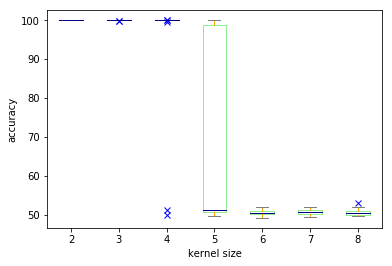

In [91]:
plt.rcParams["figure.figsize"] = (6,4)
color = dict(boxes='LightGreen', whiskers='Orange', medians='DarkBlue', caps='Gray')
results.plot.box(color=color, sym='bx')
plt.xlabel("kernel size")
plt.ylabel("accuracy")
plt.savefig("kernel_sizes.pdf")